# Project 6: OLAP Analysis – Holiday Sales Trends by Age Group

## Task 1: Choose a Business Goal

#### Goal  
Identify the monthly sales trends by product category for the year 2025 and analyze sales distribution across stores to optimize inventory allocation.

#### Actionable Result  
Enable the sales and inventory team to allocate stock more effectively based on monthly demand trends and store performance.

#### Dimensions & Sources  
| Dimension        | Table           | Source Column     | Transformation/Notes          |
| ---------------- | --------------- | ----------------- | ----------------------------- |
| Product Category | sales_data.csv  | product_category  | No transformation             |
| Month            | sales_data.csv  | sale_date        | Extract month from sale_date  |
| Year             | sales_data.csv  | sale_date        | Extract year from sale_date   |
| Store ID         | sales_data.csv  | store_id          | No transformation             |

#### Numeric Metrics  
| Metric       | Table           | Source Column | Transformation/Notes |
| ------------ | --------------- | ------------- | -------------------- |
| Sales Amount | sales_data.csv  | sale_amount   | Sum aggregation      |

#### Aggregations & Grouping  
- Sum sales_amount grouped by product_category and month (for trend analysis)  
- Sum sales_amount grouped by product_category and store_id (for distribution)  

#### Slicing  
Filter sales data to year = 2025

#### Dicing  
Break down sales by product_category and store_id

#### Drilldown  
Year → Month → Day

## Section 2: Plan your OLAP Analysis 

### Title: "Monthly Sales Trends by Product Category and Sales Distribution by Store in 2025"

#### Charts
- **Line chart:** Monthly sales trend for each product category  
  - **X-axis:** Month  
  - **Y-axis:** Total Sales  
  - **Legend:** Product Category

- **Heatmap:** Total sales by product category (rows) and store ID (columns)

#### Axis Labels & Legend
| Chart     | X-axis Label | Y-axis Label | Legend / Rows / Columns       |
|-----------|--------------|--------------|------------------------------|
| Line chart| Month        | Total Sales  | Product Category (hue)        |
| Heatmap   | Store ID     | (Color scale)| Rows = Product Category, Columns = Store ID |

#### Workflow
| Step                               | Data/Columns Needed               | Operation                                                | Output Columns                       |
|-----------------------------------|---------------------------------|----------------------------------------------------------|------------------------------------|
| Load Data                        | All columns from CSV              | Read into Spark DataFrame                                | Full DataFrame                     |
| Extract Year and Month           | `sale_date`                      | Extract year and month                                   | Add `Year`, `Month` columns        |
| Filter for 2025                  | `Year`                          | Filter rows where `Year == 2025`                         | Filtered data for 2025              |
| Aggregate monthly sales          | `product_category`, `Month`, `sale_amount` | Sum `sale_amount` grouped by `product_category` and `Month` | `product_category`, `Month`, `TotalSales` |
| Aggregate sales by category & store | `product_category`, `store_id`, `sale_amount` | Sum `sale_amount` grouped by `product_category` and `store_id` | `product_category`, `store_id`, `TotalSales` |

## Section 3: Implement OLAP Analysis 

### Section 3.1: Select and Configure Your Tools

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, year, month, dayofmonth, sum as spark_sum
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Spark session (if not already)
spark = SparkSession.builder.appName("OLAP_Project").getOrCreate()

# Absolute file paths (change these to your actual paths)
sales_path = "/Users/katehuntsman/Documents/Business Intelligence/smart-store-huntsman/data/raw/sales_data.csv"
products_path = "/Users/katehuntsman/Documents/Business Intelligence/smart-store-huntsman/data/raw/products_data.csv"

# Step 1: Load data
df_sales = spark.read.csv(sales_path, header=True, inferSchema=True)
df_products = spark.read.csv(products_path, header=True, inferSchema=True)


25/06/03 16:07:19 WARN Utils: Your hostname, Kates-MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.0.91 instead (on interface en0)
25/06/03 16:07:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/03 16:07:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/03 16:07:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Section 3.2: Perform Data Analysis

In [2]:
# Join sales with products to get product_category, rename to product_category
df_sales = df_sales.join(
    df_products.select("ProductID", "Category"),
    on="ProductID",
    how="left"
).withColumnRenamed("Category", "product_category")

# Convert SaleDate to date type and extract Year, Month, Day
df_sales = df_sales.withColumn("SaleDate", to_date("SaleDate")) \
                   .withColumn("Year", year("SaleDate")) \
                   .withColumn("Month", month("SaleDate")) \
                   .withColumn("Day", dayofmonth("SaleDate"))

# Slicing - filter sales for 'Electronics' in 2025
df_slice = df_sales.filter((df_sales.product_category == 'Electronics') & (df_sales.Year == 2025))

# Dicing - aggregate total sales by product_category and StoreID for 2025
df_dice = df_sales.filter(df_sales.Year == 2025) \
                  .groupBy("product_category", "StoreID") \
                  .agg(spark_sum("SaleAmount").alias("TotalSales")) \
                  .orderBy("product_category", "StoreID")

# Drilldown - aggregate sales Year → Month → Day for 2025
df_drilldown = df_sales.filter(df_sales.Year == 2025) \
                       .groupBy("Year", "Month", "Day") \
                       .agg(spark_sum("SaleAmount").alias("TotalSales")) \
                       .orderBy("Year", "Month", "Day")

# Prepare monthly sales trend by product category (sum sales grouped by product_category and month)
monthly_sales = df_sales.filter(df_sales.Year == 2025) \
                        .groupBy("product_category", "Month") \
                        .agg(spark_sum("SaleAmount").alias("TotalSales")) \
                        .orderBy("product_category", "Month")

# Convert to Pandas for plotting
monthly_sales_pd = monthly_sales.toPandas()
dice_pd = df_dice.toPandas()

### Section 3.3: Test and Validate

In [3]:
from pyspark.sql.functions import sum as spark_sum

# 1. Test that your key filters (slicing) actually applied correctly
print("Distinct years in data:", df_sales.select("Year").distinct().rdd.flatMap(lambda x: x).collect())
assert 2025 in df_sales.select("Year").distinct().rdd.flatMap(lambda x: x).collect(), "2025 missing from data"

# 2. Validate that sales amounts are positive and reasonable
total_sales = df_sales.agg(spark_sum("SaleAmount")).collect()[0][0]
print(f"Total sales amount in dataset: {total_sales}")
assert total_sales > 0, "Total sales amount should be positive"

# 3. Validate aggregation correctness with simple queries
# Aggregate sales by product category and month (Slicing + Drilldown)
monthly_sales = df_sales.filter(df_sales.Year == 2025) \
    .groupBy("product_category", "Month") \
    .agg(spark_sum("SaleAmount").alias("TotalSales")) \
    .orderBy("product_category", "Month")

# Sum sales from this aggregation
agg_sum = monthly_sales.agg(spark_sum("TotalSales")).collect()[0][0]
print(f"Sum of monthly aggregated sales: {agg_sum}")

# Compare with total sales from raw filtered data (should be equal)
raw_sum = df_sales.filter(df_sales.Year == 2025).agg(spark_sum("SaleAmount")).collect()[0][0]
print(f"Sum of raw sales data for 2025: {raw_sum}")

assert abs(agg_sum - raw_sum) < 0.01, "Aggregated sales and raw sales totals differ — check aggregation logic"

# 4. Check for null or missing critical values (product category, sale amount)
null_cat_count = df_sales.filter(df_sales.product_category.isNull()).count()
null_sales_count = df_sales.filter(df_sales.SaleAmount.isNull()).count()
print(f"Rows with null product_category: {null_cat_count}")
print(f"Rows with null SaleAmount: {null_sales_count}")
assert null_cat_count == 0, "Null product_category found"
assert null_sales_count == 0, "Null SaleAmount found"

# 5. Business validation: Does the pattern look actionable?
# (Print sample top categories by total sales)
top_categories = df_sales.groupBy("product_category") \
    .agg(spark_sum("SaleAmount").alias("TotalSales")) \
    .orderBy("TotalSales", ascending=False) \
    .limit(5) \
    .collect()
print("Top 5 product categories by sales:")
for row in top_categories:
    print(f"Category: {row['product_category']}, Total Sales: {row['TotalSales']}")

# 6. Validate dicing: sales breakdown by product and store
sales_by_store = df_sales.filter(df_sales.Year == 2025) \
    .groupBy("product_category", "StoreID") \
    .agg(spark_sum("SaleAmount").alias("TotalSales")) \
    .orderBy("product_category", "StoreID")
print(f"Sample sales by store (first 5 rows):")
sales_by_store.show(5)


Distinct years in data: [2025, None]
Total sales amount in dataset: 2028538.5100000005
Sum of monthly aggregated sales: 2027800.9799999995
Sum of raw sales data for 2025: 2027800.9800000004
Rows with null product_category: 0
Rows with null SaleAmount: 0
Top 5 product categories by sales:
Category: Home, Total Sales: 581360.5800000001
Category: Electronics, Total Sales: 505997.7800000002
Category: Clothing, Total Sales: 480925.53999999934
Category: Office, Total Sales: 460254.61
Sample sales by store (first 5 rows):
+----------------+-------+------------------+
|product_category|StoreID|        TotalSales|
+----------------+-------+------------------+
|        Clothing|    401|125353.58999999998|
|        Clothing|    402|118365.62999999999|
|        Clothing|    403|126308.16000000002|
|        Clothing|    404|110160.62999999999|
|     Electronics|    401|122549.04000000005|
+----------------+-------+------------------+
only showing top 5 rows



## Task 4: Present Results and Visualizations

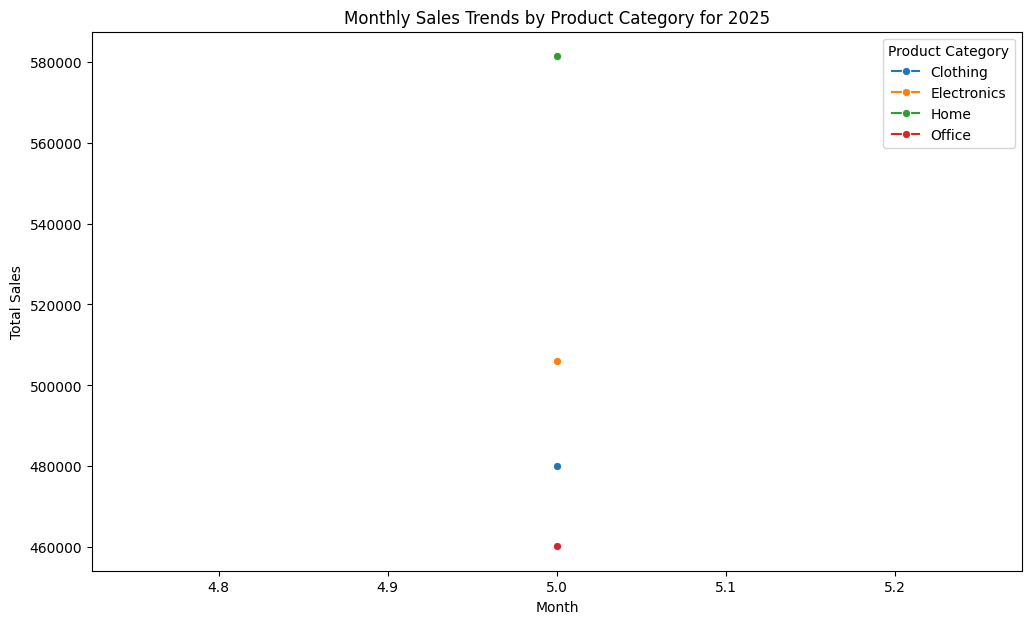

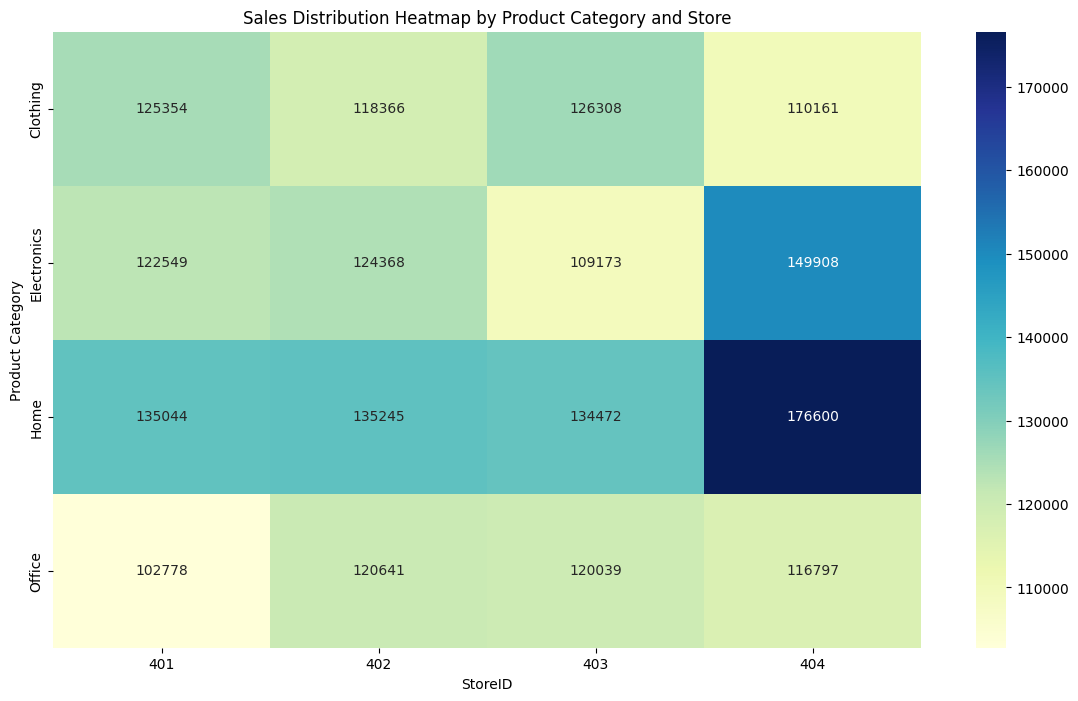

In [4]:
# Plot 1: Monthly Sales Trends by Product Category
plt.figure(figsize=(12, 7))
sns.lineplot(data=monthly_sales_pd, x='Month', y='TotalSales', hue='product_category', marker="o")
plt.title("Monthly Sales Trends by Product Category for 2025")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.legend(title='Product Category')
plt.show()

# Plot 2: Heatmap of Sales Distribution by Product Category and StoreID (using dicing result)
# Pivot dice data for heatmap: rows=product_category, columns=StoreID, values=TotalSales
pivot_table = dice_pd.pivot(index='product_category', columns='StoreID', values='TotalSales').fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Sales Distribution Heatmap by Product Category and Store")
plt.xlabel("StoreID")
plt.ylabel("Product Category")
plt.show()
